<a href="https://colab.research.google.com/github/Nano1337/PytorchPractice/blob/main/PyTorch_60_min_Blitz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Include Dependencies

In [1]:
import torch
import numpy as np

# Tensor Basics

Tensors

In [10]:
# creating from data
data = [[1, 2], [3, 4]]
x_data = torch.tensor(data)

# create from numpy array
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

# inherit dimensions from other tensors
x_ones = torch.ones_like(x_data)
x_rand = torch.rand_like(x_data, dtype=torch.float)

# declare tensor with specified shape just like in numpy 
# get shape, datatype, and device tensor is located on

Tensor operations

In [3]:
tensor = torch.ones((2, 3))
# move tensor to GPU if available
if torch.cuda.is_available():
  tensor = tensor.to('cuda')
  print(f"Device tensor is stored on: {tensor.device}")

# note that tensor and numpy array share memory (pass by reference)

Device tensor is stored on: cuda:0


# Autograd

Run single pass through resnet18

In [5]:
import torch, torchvision
model = torchvision.models.resnet18(pretrained=True)
data = torch.rand(1, 3, 64, 64)
labels = torch.rand(1, 1000)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# run a forward pass
prediction = model(data)

# loss function is sum of all the losses
loss = (prediction - labels).sum()

# run a backward pass
loss.backward()

In [7]:
# load SGD optimizer
optim = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

# initiate gradient descent
optim.step()

How autograd collections gradients

In [9]:
# explicitly state that tensor must track gradients (also stored in same variable)
a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

# find gradients of this equation with respect to a and b
Q = 3*a**3 - b**2

# automatically calculate both gradients at once
external_grad = torch.tensor([1., 1.])
Q.backward(gradient=external_grad)



In [11]:
# NOTE: explicitly setting requires_grad=False is useful for freezing parameters during fine tuning
from torch import nn, optim

model = torchvision.models.resnet18(pretrained=True)

# Freeze all parameters in network
for param in model.parameters():
  param.requires_grad = False

# create non-frozen fully connected last layer as classifier for 10 class outputs
model.fc = nn.Linear(512, 10) 

# optimize only the classifier
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
optimizer.step()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Neural Networks

Typical process for training a neural network: 


1.   Architecture: define the neural network (learnable params) 
2.   Batching: iterate over dataset of inputs
3.   Forward pass: process input through network
4.   Loss computation
5.   Backprop into network's params
6.   Update the weights using simple run: weight -= lr*gradient



In [9]:
''' Define Architecture, Batching, and Forward Pass '''

import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

  # define layers in ctor
  def __init__(self):
    super(Net, self).__init__()
    
    # 1 input image channel (grayscale), 6 output channels, 5x5 square convolution
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16*5*5, 120) # 5x5 from image dimension bc fc is flattened
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
  
  # define forward pass (activation functions), backward prop handled by autograd
  def forward(self, x):
    # max pooling over a (2, 2) window
    x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
    # if size is square, you can specify with a single number
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = torch.flatten(x, 1) # flatten all dim except batch dim
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x) # no activation on output layer
    return x

net = Net()

In [19]:
''' Loss computation, Backprop, and Updating weights'''

import torch.optim as optim

# update weights using optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)
criterion = nn.MSELoss()

# in training loop
x = 3
for i in range(x):
  net.zero_grad() # clear gradients from previous backprop
  out = net(torch.randn(1, 1, 32, 32))
  target = torch.randn(10) # dummy target
  target = target.view(1, -1) # make it the same shape as output (prepend additional dim)
  loss = criterion(out, target)
  loss.backward() # backprop
  optimizer.step() # does the 
  print(loss)


tensor(1.2069, grad_fn=<MseLossBackward0>)
tensor(0.8984, grad_fn=<MseLossBackward0>)
tensor(0.5017, grad_fn=<MseLossBackward0>)


# Train an image classifier

Steps: 

1.   Load and normalize CIFAR10 training and test datasets
2.   Define architecture
3.   Define loss function (criterion)
4.   Train network on training data
5.   Test network on test data

In [36]:
import torch
import torchvision
import torchvision.transforms as transforms

In [37]:
# load CIFAR10 and transform from PIL [0, 1] to tensors [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 8

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, 
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


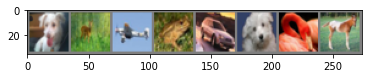

dog   deer  plane frog  car   dog   bird  horse


In [38]:
# analyze training images

import matplotlib.pyplot as plt

def imshow(img): 
  img = img/2 + 0.5 # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# get some random training images
dataiter = iter(trainloader) # haha iterator like in c++
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))

In [51]:
''' Define Architecture, Batching, and Forward Pass '''

import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

  # define layers in ctor
  def __init__(self):
    super(Net, self).__init__()
    
    # 1 input image channel (grayscale), 6 output channels, 5x5 square convolution
    self.conv1 = nn.Conv2d(3, 16, 5)
    self.conv2 = nn.Conv2d(16, 20, 5)
    self.fc1 = nn.Linear(20*5*5, 200) # 5x5 from image dimension bc fc is flattened
    self.fc2 = nn.Linear(200, 100)
    self.fc3 = nn.Linear(100, 10)
  
  # define forward pass (activation functions), backward prop handled by autograd
  def forward(self, x):
    # max pooling over a (2, 2) window
    x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
    # if size is square, you can specify with a single number
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = torch.flatten(x, 1) # flatten all dim except batch dim
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x) # no activation on output layer
    return x

net = Net()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
print(device)

cuda:0


In [52]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [53]:
# define train loop
losses = []
num_epochs = 10
for epoch in range(num_epochs):
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data

    # send data to device
    inputs, labels = inputs.to(device), labels.to(device)

    # zero parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print stats of epoch
    running_loss += loss.item()
    if i % 2000 == 1999: # print every 2000 mini-batches
      print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
      losses.append(running_loss)
      running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.091
[1,  4000] loss: 1.689
[1,  6000] loss: 1.528
[2,  2000] loss: 1.409
[2,  4000] loss: 1.327
[2,  6000] loss: 1.279
[3,  2000] loss: 1.193
[3,  4000] loss: 1.152
[3,  6000] loss: 1.140
[4,  2000] loss: 1.055
[4,  4000] loss: 1.023
[4,  6000] loss: 1.023
[5,  2000] loss: 0.953
[5,  4000] loss: 0.940
[5,  6000] loss: 0.922
[6,  2000] loss: 0.846
[6,  4000] loss: 0.866
[6,  6000] loss: 0.860
[7,  2000] loss: 0.780
[7,  4000] loss: 0.793
[7,  6000] loss: 0.797
[8,  2000] loss: 0.708
[8,  4000] loss: 0.736
[8,  6000] loss: 0.753
[9,  2000] loss: 0.664
[9,  4000] loss: 0.680
[9,  6000] loss: 0.691
[10,  2000] loss: 0.599
[10,  4000] loss: 0.644
[10,  6000] loss: 0.642
Finished Training


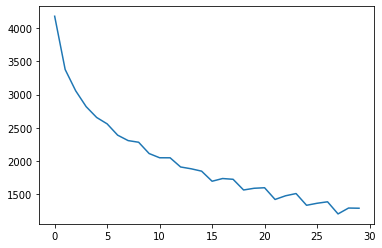

In [54]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [55]:
# save model 
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

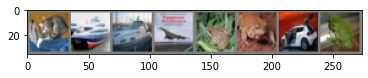

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog 


<All keys matched successfully>

In [56]:
''' test model '''
dataiter = iter(testloader) # define dataloader iterator
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

net = Net()
net.load_state_dict(torch.load(PATH))

In [57]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predict: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(8)))

Predict:  dog   ship  truck plane deer  frog  frog  frog 


In [58]:
# assess on entire dataset
correct = 0
total = 0
# since we're eval, don't neet to calc gradients for outputs
with torch.no_grad():
  for i, data in enumerate(testloader):
    images, labels = data

    # calc outputs by running forward pass
    outputs = net(images)
    
    #class with highest prob is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 69 %


In [59]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 79.9 %
Accuracy for class: car   is 78.6 %
Accuracy for class: bird  is 54.3 %
Accuracy for class: cat   is 38.9 %
Accuracy for class: deer  is 68.7 %
Accuracy for class: dog   is 66.0 %
Accuracy for class: frog  is 82.1 %
Accuracy for class: horse is 69.1 %
Accuracy for class: ship  is 78.6 %
Accuracy for class: truck is 77.1 %
